In Python, we need to import various libraries to help us with reading/manipulating data (Pandas), performing numerical calculations (NumPy) and plotting data (Matplotlib). For more information on all these libraries please see the course notes for GEOG-G489/589 Big Data Geospatial Analysis in Python: https://github.com/nmacbean/GEOG-G489-589

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exercise 2: Model Evaluation

In this exercise we will use the same model code that we defined in Exercise 1 "Building a simple 2 pool carbon cycle model". First we redefine the model code and read in inputs. In the second part of the exercise we will also read in some observations that we will use to evaluate the model.

Learning outcomes:
- Practice how to evaluate model by plotting against a timeseries of observations.
- Learn about typical metrics we use to evaluate models.

## Model Code

As we learnt in Exercise 1 "Building the Model", we first need to set up the model code. The code boxes below are ordered in a typical structure we might have in a model script:
1. Defining parameters and unit conversions
2. Read input data and calculate the number of timesteps.
2. Initialize model variables
3. Equations for the model limitation functions
4. Code for running the actual model - i.e. looping over timesteps

In [2]:
# -
# - set default parameters
# -
Q10 = 2.
Tref = 303.15    # 30 degrees C in K
Wf_m = -2.
Wf_x0 = 0.6
Wf_min = 0.05
Wf_max = 1.
tau_litter = 0.5
tau_soil = 60
Me_litter = 0.3
Me_soil = 0.1
C_litter_t0 = 3
C_soil_t0 = 22

# -
# - other 
# - 
dt = 1/365.
npools = 2

In [3]:
# - unit conversions
degC_to_K = 273.15
gC_to_kgC = 1e-3

In [4]:
# - read in inputs
input_file = 'inputs/carbon_2pool_model_inputs.csv'
input_data = pd.read_csv(input_file, index_col=0)

# - convert temperature to K
input_data.LITTER_TEMP += degC_to_K
input_data.SOIL_TEMP += degC_to_K

# - convert litter input to kgC
input_data.LITTER_INPUT *= gC_to_kgC

In [5]:
# - calculate the number of timesteps from the input data
ntsteps = len(input_data.index)

In [6]:
# -
# - initialize model variables
# -

# - litter and soil C pools (want to save time series)
Cpools = np.zeros((ntsteps+1, npools))
Cpools[0,0] = C_litter_t0
Cpools[0,1] = C_soil_t0

# - litter and soil Rh (want to save timeseries)
Rh = np.zeros((ntsteps, npools))

# - total C decomp each tstep
Cdecomp = np.zeros(npools)

# - total C transferred
Ctrans = np.zeros(npools)

In [7]:
# -
# - temperature function for litter and soil
# -
ftemp_litter = Q10**((input_data.LITTER_TEMP - Tref)/10.)
ftemp_soil = Q10**((input_data.SOIL_TEMP - Tref)/10.)

In [8]:
# -
# - moisture function
# -
fmoist_litter = np.maximum(Wf_min, Wf_max + Wf_m * ( (input_data.LITTER_MOIST - Wf_x0)**2 ))
fmoist_soil = np.maximum(Wf_min, Wf_max + Wf_m * ( (input_data.SOIL_MOIST - Wf_x0)**2 ))

In [9]:
# -
# - begin model simulations
# -

# - set up for loop over total number of timesteps in input data
for nt in np.arange(ntsteps):
    
    # - calculate the total amount of C decomposed in each pool (prior to splitting between C transferred and Rh) (Eq. 1)
    Cdecomp[0] = Cpools[nt,0] * (dt/tau_litter) * ftemp_litter[nt] * fmoist_litter[nt]
    Cdecomp[1] = Cpools[nt,1] * (dt/tau_soil) * ftemp_soil[nt] * fmoist_soil[nt]
    
    # - calculate the fraction of C transferred from one pool to the other (Eqns. 2 and 4)
    Ctrans[0] = Cdecomp[0] * Me_litter
    Ctrans[1] = Cdecomp[1] * Me_soil
    
    # - calculate the heterotrophic respiration in each pool (Eqns. 3 and 5)
    Rh[nt,0] = Cdecomp[0] * (1. - Me_litter)
    Rh[nt,1] = Cdecomp[1] * (1. - Me_soil)
    
    # - calculate evolution of C pools (Eqns. 6 and 7) --> NOTE: updating C pool from current to next tstep
    Cpools[nt+1,0] = Cpools[nt,0] + input_data.LITTER_INPUT[nt] - Cdecomp[0] + Ctrans[1]
    Cpools[nt+1,1] = Cpools[nt,1] + Ctrans[0] - Cdecomp[1]

# -
# - end of the model
# -

-------
Note that in a larger model these different components might be defined in different scripts that we might refer to as "modules", i.e. the parameters would be defined in one script, inputs read in in another etc. The input data (and outputs) would then get passed around different modules as different components were calculated (e.g. first photosynthetic C uptake in one script, allocation to different biomass pools in another, litterfall in another etc).

## Model Evaluation

Model evaluation - comparing model simulations to independent data/observations - is a very standard part of the model development cycle:

![model development](model_development_figure.png)

Model evaluation is also often called model benchmarking.

Only by comparing to observations can we see if the model comes close to representing reality. Ideally, model evaluation will be performed across a range of sites/biomes and scales (i.e. site level to global scale products such as satellite-derived datasets).

One initiative to facilitate comprehensive model evaluation is the International Land Model Benchmarking (ILAMB) Project: https://www.ilamb.org. They provide a suite of tools with which you can evaluate your model across a wide variety of datasets.

Typical metrics that we use to evaluate the models are:

* Absolute bias (e.g. model - observations)
* RMSE
* Correlation (R) or R$^{2}$
* Monthly or annual mean or total
* Mean seasonal cycle (mean for each day or month over several years)
* Long-term (often annual) trend
* Inter-annual variability (annual mean/total - the long-term mean/total over the whole timeseries)


**Question: when reading literature for your in-class project have you come across any other metrics and/or methods for evaluating models with observations? If so, what are those metrics/methods (briefly)? Include a reference if that helps.**

ANSWER: Depends on your project...


We will calculate some of these metrics in upcoming classes. For now, we will just plot the daily model against the daily observations to see the general patterns between the model and the observations.

In the code boxes below we're going to read in a csv file containing observations for:

- Litter Rh
- Soil Rh
- Total Rh (litter plus soil)
- Litter C
- Soil C
- Total C (litter plus soil)

The units are gCm$^{-2}$dt$^{-1}$ for Rh and kgCm$^{-2}$ for the C stocks.

We use the same code as we used to read in the inputs:

In [14]:
# - read in observations
obs_file = 'obs/carbon_2pool_model_obs.csv'
obs = pd.read_csv(obs_file, index_col=0)
print(obs.head())

       Rh_litter   Rh_soil  Rh_total  C_litter     C_soil    C_total
TSTEP                                                               
0       0.970152  0.758216  1.728368  4.570169  21.359884  25.930054
1       1.333419  0.930100  2.263519  4.569037  21.360292  25.929329
2       1.896636  1.258065  3.154700  4.566769  21.360943  25.927711
3       2.038155  1.399666  3.437821  4.564220  21.361593  25.925814
4       1.062093  0.976790  2.038883  4.563635  21.361677  25.925312


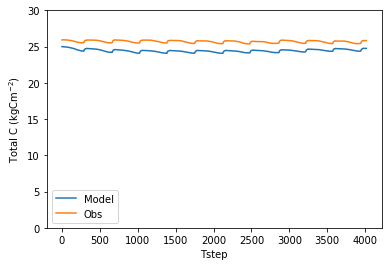

In [19]:
# - plot C stock for soil pool compared to the observations(changed axes limits to 0 to 30kgC/m2)
tot_Cpools = Cpools[:,0] + Cpools[:,1]    # - equivalent to np.sum(Cpools, axis=1) for those familiar with Python
plt.plot(tot_Cpools, label='Model')
plt.plot(obs.C_total, label='Obs')
plt.xlabel('Tstep')
plt.ylabel('Total C (kgCm$^{-2}$)')
plt.ylim(0,30)
plt.legend()
plt.show()

**Exercise: in the box below modify the code above to plot the model timeseries compared to the observations for 1) the litter Rh; 2) the soil Rh; 3) the total Rh (litter + soil); 4) Litter C and 5) Soil C.** Add a label for the model and obs and plot the legend so you know which curve is which. Change the axes titles and y-axis limits as needed. 
*Then answer the questions below.*

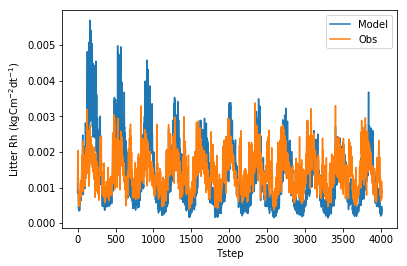

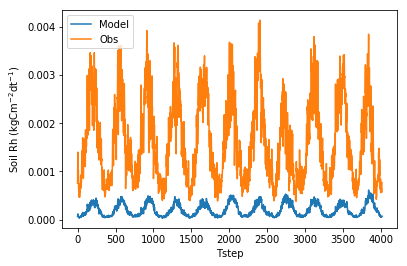

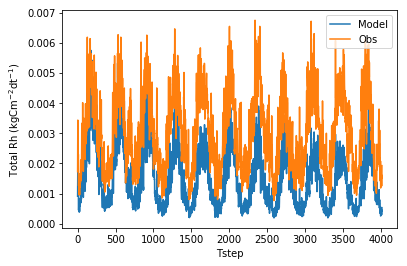

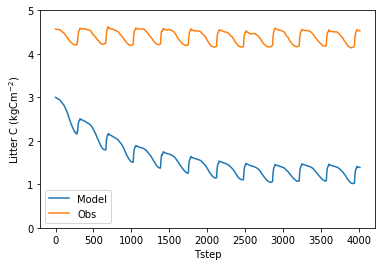

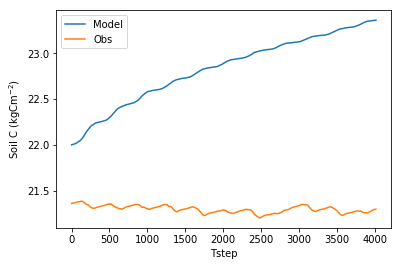

In [17]:
# - write code here

# - plot Rh_litter model vs obs
plt.plot(Rh[:,0], label='Model')
plt.plot(obs.Rh_litter*gC_to_kgC, label='Obs')
plt.xlabel('Tstep')
plt.ylabel('Litter Rh (kgCm$^{-2}$dt$^{-1}$)')
plt.legend()
plt.show()

# - plot Rh_soil model vs obs
plt.plot(Rh[:,1], label='Model')
plt.plot(obs.Rh_soil*gC_to_kgC, label='Obs')
plt.xlabel('Tstep')
plt.ylabel('Soil Rh (kgCm$^{-2}$dt$^{-1}$)')
plt.legend()
plt.show()

# - total Rh
tot_rh = np.sum(Rh, axis=1)
plt.plot(tot_rh, label='Model')
plt.plot(obs.Rh_total*gC_to_kgC, label='Obs')
plt.xlabel('Tstep')
plt.ylabel('Total Rh (kgCm$^{-2}$dt$^{-1}$)')
plt.legend()
plt.show()

# - litter C pool
plt.plot(Cpools[:,0], label='Model')
plt.plot(obs.C_litter, label='Obs')
plt.xlabel('Tstep')
plt.ylabel('Litter C (kgCm$^{-2}$)')
plt.ylim(0,5)
plt.legend()
plt.show()

# - litter C pool
plt.plot(Cpools[:,1], label='Model')
plt.plot(obs.C_soil, label='Obs')
plt.xlabel('Tstep')
plt.ylabel('Soil C (kgCm$^{-2}$)')
#plt.ylim(0,30)
plt.legend()
plt.show()

Now answer the following questions:

**Question: What do you notice about all the respiration plots? Why are the curves so different? [Hint: think about units]**

ANSWER: When we originally input the litter Rh data the units were gCm$^{-2}$d$^{-1}$ whereas the model was in kgCm$^{-2}$d$^{-1}$; therefore, the model curve looked like it was zero compared to the observations. We need to multiply the observations by the gC_to_kgC scalar (as we originally did for the input data) so we can directly compare model and observations. We do this below.

**Exercise: modify the code above so the Rh model and observation curves can be directly compared. Once you have modified the code, answr the following questions.**

**Questions: i) Is the model total Rh overestimating or underestimating the observations? ii) Which Rh flux (litter or soil) is contributing most to this bias?**

ANSWERS: i) the model is underestimating the observations; ii) the soil Rh has a greater negative bias (model - obs) compared to the litter Rh.

**Questions: i) What is the difference between the model and observed litter and soil C pool? ii) Why do you think this is? iii) And why do you think these differences are not as easily observed when looking at the timeseries for the total soil C?**

ANSWERS: 
i) the model litter and soil C pools are changing over time, whereas the observations show more stability in the C pools over time;  
ii) as discussed in the previous exercise, the model is not in equilibrium and therefore the values are changing over time - however, clearly in the observations both pools are more or less stable. This is likely mostly because the initial C pools and other parameters (e.g. turnover rate) are not quite right in the model yet, whereas in reality the two pools are in equilibrium. Given we are only running over a short time period and we have guessed the initial soil C content it is possible that this is the main problem in the model;  
iii) this depends on what scale you plot your data on. In the original example I set the y-axis limits to between 0 and 30. Given the changes in the soil C or total C are small within that range, it is hard to see the differences. However, if you remove the ylims code you can more easily see the differences between the model and observations.

*Note, that we would need to do a sensitivity analysis to check the effect of changing the initial soil C (to come in Exercise 3) and if we really wanted to get the model to match the observations we would do use data assimilation - the process of statistically optimizing a model against observations - to calibrate all the parameters to better match the observations (to come in Exercise 4). This data assimilation experiment would ideally find the optimum intial C pool values coupled with a more realistic turnover rate so that the model was more stable over time.*


**That's it for this model evaluation exercise. Complete all the exercises and questions and upload your jupyter notebook to Canvas.**